# Figure 2

In [1]:
# data analysis
import xarray as xr
import numpy as np
import pandas as pd
import cosima_cookbook as cc

# plotting
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cmocean as cmo

Import Dask

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35909/status,
Dashboard: /proxy/35909/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35233,Workers: 7
Dashboard: /proxy/35909/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:39209,Total threads: 4
Dashboard: /proxy/35863/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:44023,


Read in runoff input files. 

In [5]:
control = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/V1-3/RYF.runoff_all.1990_1991.nc')['friver']
ssp245 = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp245_mw/RYF.runoff_all.1990_1991.nc')['friver']
ssp585 = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp585_mw/RYF.runoff_all.1990_1991.nc')['friver']

Extract runoff south of 59S (i.e. around Antarctica) and convert to Sverdrup. 

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371*1000 # Radius of earth in m. 
    return c * r

In [7]:
distance_yt = control.isel(time=0).isel(latitude = 0).copy(deep=True)
distance_yt = distance_yt.rename('distance_yt')
distance_yt.attrs['units'] = 'm'
distance_yt.attrs['long_name'] = 'distance along grid cell in meridional direction'
distance_yt.attrs['standard_name'] = 'distance along grid cell in meridional direction'
distance_yt

distance_xt = control.isel(time=0).isel(longitude = 0).copy(deep=True)
distance_xt = distance_xt.rename('distance_xt')
distance_xt.attrs['units'] = 'm'
distance_xt.attrs['long_name'] = 'distance along grid cell in zonal direction'
distance_xt.attrs['standard_name'] = 'distance along grid cell in zonal direction'

# Grid cell lengths
for j, lat in enumerate(control.latitude.values):
    distance_xt[j] = haversine(distance_xt.longitude.values, lat, distance_xt.longitude.values+0.25, lat)
# print(distance_xt.values[0:20])

for i, lon in enumerate(control.longitude.values):
    distance_yt[i] = haversine(lon, distance_yt.latitude.values, lon, distance_yt.latitude.values + 0.25)
# print(distance_yt.values[0:20])

# calculate area [m2]
area = distance_xt * distance_yt

In [8]:
control = (control*area.values/1000/1000000).sel(latitude=slice(None, -59))
ssp245 = (ssp245*area.values/1000/1000000).sel(latitude=slice(None, -59))
ssp585 = (ssp585*area.values/1000/1000000).sel(latitude=slice(None, -59))
# Note, these are 0.25 degree grids

In [9]:
control_Sv = control.isel(time=-1).sel(latitude=slice(None, -60)).sum().values
ssp245_Sv = ssp245.isel(time=-1).sel(latitude=slice(None, -60)).sum().values
ssp585_Sv = ssp585.isel(time=-1).sel(latitude=slice(None, -60)).sum().values

print(control_Sv, ssp245_Sv, ssp585_Sv)

0.08746009475231172 0.14206009475231168 0.2954600947523117


We want to plot this as a value per degree of longitude so that it could be compared against other studies with different grids. The data is currently on a 0.25 degree grid so we need to resample the runoff across 4 grid cells. 

In [11]:
# reorder and concatenate data so that longitude matches later figures in paper

# first define new longitudes
new_lon = np.concatenate((control.longitude[320:].values, control.longitude[:320].values))
new_lon[new_lon > 80] = new_lon[new_lon > 80] - 360
control = xr.concat((control[:,:,320:], control[:,:,0:320]), dim='longitude')
ssp245 = xr.concat((ssp245[:,:,320:], ssp245[:,:,0:320]), dim='longitude')
ssp585 = xr.concat((ssp585[:,:,320:], ssp585[:,:,0:320]), dim='longitude')

# replace longitude coordinate values with modified longitude values
control['longitude'] = new_lon
ssp245['longitude'] = new_lon
ssp585['longitude'] = new_lon

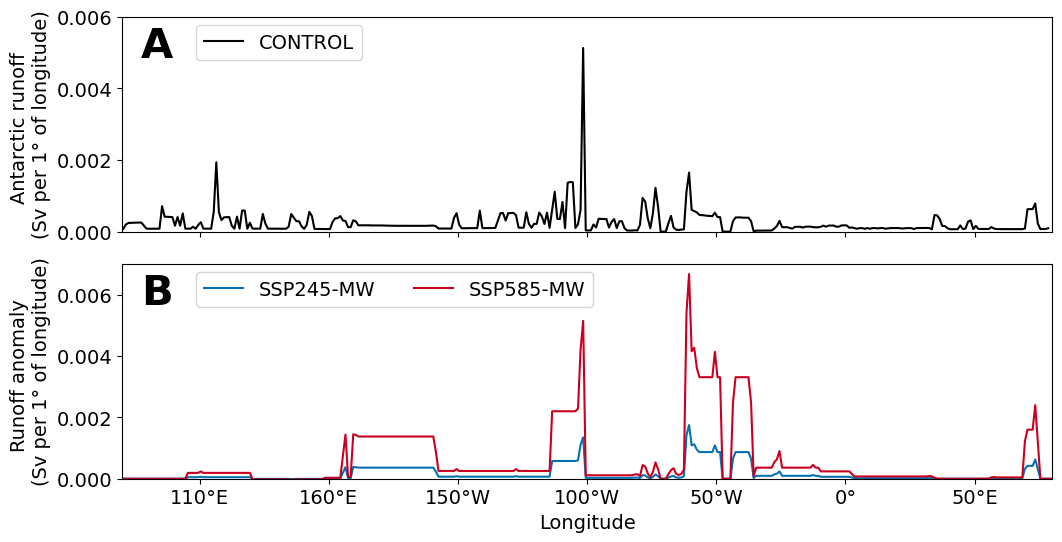

In [12]:
# create figure
colours = ['k', '#92c5de', '#0571b0', '#fdae61', '#ca0020', ]
lw=1.5

plt.rcParams['font.size'] = 14
figure, axes = plt.subplots(nrows = 2, figsize = (12, 6), sharex=True)
plt.subplots_adjust(hspace=0.15)

lon_resample = control.coarsen(longitude=4, side='center').sum('longitude').longitude
control_resample = control.coarsen(longitude=4, side='center').sum('longitude').mean('time').sum('latitude')
ssp245_resample = ssp245.coarsen(longitude=4, side='center').sum('longitude').mean('time').sum('latitude')
ssp585_resample = ssp585.coarsen(longitude=4, side='center').sum('longitude').mean('time').sum('latitude')

axes[0].plot(lon_resample[:-1], control_resample[:-1], c='k', lw=lw, label='CONTROL')
axes[1].plot(lon_resample, (ssp245_resample - control_resample), 
             c=colours[2], lw=lw, label='SSP245-MW')
axes[1].plot(lon_resample, (ssp585_resample - control_resample), 
             c=colours[4], lw=lw, label='SSP585-MW')

axes[0].set_xlim([-280,80])
axes[0].set_ylim([0,0.006])
axes[1].set_ylim([0,0.007])
axes[1].set_xlabel('Longitude')
axes[1].set_xticklabels(['','110\u00b0E','160\u00b0E','150\u00b0W','100\u00b0W','50\u00b0W','0\u00b0','50\u00b0E'])
axes[0].set_ylabel(f'Antarctic runoff \n(Sv per 1\u00b0 of longitude)')
axes[1].set_ylabel('Runoff anomaly \n(Sv per 1\u00b0 of longitude)')
axes[0].legend(loc='upper center')
axes[0].legend(loc=[0.08,0.8])
axes[1].legend(loc=[0.08,0.8], ncols=2)
axes[0].text(0.02, 0.81, 'A',  c='k', fontsize=30, fontweight='bold', transform=axes[0].transAxes)
axes[1].text(0.02, 0.81, 'B',  c='k', fontsize=30, fontweight='bold', transform=axes[1].transAxes)

# save to file
save_flag = 0
figfile = '../figs/Fig02_resampled.jpg'
if save_flag == 1:
    figure.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()